<a href="https://colab.research.google.com/github/ZZYActSci/Machine-Learning-Projects/blob/main/carpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using Reinforcement Learning, train an agent to play Cartpole V1 (OpenAI Gym environment). All python libraries are accepted.

Cite all used resources used for your work.



Requirements
1. Code is bug-free.

2. Mean reward above 475 on the last 100 episodes

3. Graph mean reward over episodes

## Part 1: Exploration of attributes

In [1]:
%%capture
!apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
!pip install -q -U tf-agents-nightly pyvirtualdisplay gym[atari]

In [2]:
import gym
import numpy as np
from tensorflow import keras
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

In [3]:
# gym.envs.registry.all()

In [4]:
# https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py
env = gym.make('CartPole-v1')
env._max_episode_steps = 500

In [5]:
env.seed(42)
obs = env.reset()
obs

array([-0.01258566, -0.00156614,  0.04207708, -0.00180545])

In [6]:
try:
    import pyvirtualdisplay
    display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
except ImportError:
    pass

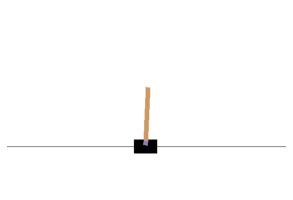

In [7]:
env.render( )

def plot_environment(env, figsize=(5,4)):
  plt.figure(figsize=figsize)
  img = env.render(mode='rgb_array')
  plt.imshow(img)
  plt.axis('off')
  return img

plot_environment(env)
plt.show()

In [8]:
env.action_space

Discrete(2)

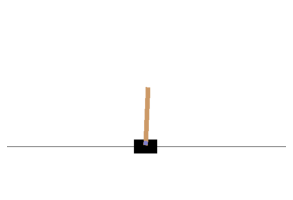

In [9]:
action=1
obs, reward, done, info = env.step(action)
obs
plot_environment(env)
plt.show()

In [10]:
obs

array([-0.01261699,  0.19292789,  0.04204097, -0.28092127])

In [11]:
reward

1.0

In [12]:
done

False

In [13]:
info

{}

In [14]:
print(env.observation_space.high)
print(env.observation_space.low)
print(env.action_space.n)

[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
2


## Part 2: Change bounds
## From above, tt seems that the velocities have unlimited space. Hard to creat bins for them. So we try to clip the space.

In [15]:
obs = env.reset()
for i in range(10):
    action = np.random.randint(2)  # always go right!
    new_state, reward, done, _ = env.step(action)
    print(reward, new_state)

1.0 [ 0.00597787  0.21404067 -0.03614886 -0.31586023]
1.0 [ 0.01025868  0.40965838 -0.04246607 -0.61972055]
1.0 [ 0.01845185  0.21515447 -0.05486048 -0.34070898]
1.0 [ 0.02275494  0.02085426 -0.06167466 -0.06581803]
1.0 [ 0.02317202 -0.17333171 -0.06299102  0.20678627]
1.0 [ 0.01970539  0.02263179 -0.05885529 -0.10508313]
1.0 [ 0.02015803 -0.1715995  -0.06095696  0.16846588]
1.0 [ 0.01672604 -0.36579836 -0.05758764  0.44131289]
1.0 [ 0.00941007 -0.16991076 -0.04876138  0.13104716]
1.0 [ 0.00601185 -0.36430153 -0.04614044  0.40795658]


In [16]:
QT_SIZE = [20] * len(env.observation_space.high)
window_size = (env.observation_space.high - env.observation_space.low) / QT_SIZE

print(window_size)

[0.48000002        inf 0.0418879         inf]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in subtract
  


In [17]:
env.observation_space.low,env.observation_space.high

(array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
       dtype=float32),
 array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
       dtype=float32))

In [18]:
env.observation_space.low = np.array([-4.8000002e+00, -5., -4.1887903e-01, -5.],dtype=np.float32)
env.observation_space.high = np.array([4.8000002e+00, 5., 4.1887903e-01, 5.],dtype=np.float32)

In [19]:
env.observation_space.low,env.observation_space.high

(array([-4.8       , -5.        , -0.41887903, -5.        ], dtype=float32),
 array([4.8       , 5.        , 0.41887903, 5.        ], dtype=float32))

In [20]:
QT_SIZE = [40] * len(env.observation_space.high)
window_size = (env.observation_space.high - env.observation_space.low) / QT_SIZE

print(window_size)

[0.24000001 0.25       0.02094395 0.25      ]


In [21]:
q_table = np.random.uniform(low=-2, high=0, size=(QT_SIZE + [env.action_space.n]))
q_table.shape

(40, 40, 40, 40, 2)

## Part 3:  Put them all together
## Changes: max steps from 200 to 500

In [23]:
env = gym.make("CartPole-v1")
env._max_episode_steps = 500
env.observation_space.low = np.array([-4.8000002e+00, -5., -4.1887903e-01, -5.],dtype=np.float32)
env.observation_space.high = np.array([4.8000002e+00, 5., 4.1887903e-01, 5.],dtype=np.float32)

LEARNING_RATE = 0.1 #0.05
DISCOUNT = 0.95 #0.9
EPISODES = 10000
QT_SIZE = [40] * len(env.observation_space.high)
window_size = (env.observation_space.high - env.observation_space.low) / QT_SIZE

# Explore
epsilon = 0.5  # not a constant, qoing to be decayed
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = EPISODES//2
epsilon_decay_value = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)

q_table = np.random.uniform(low=-2, high=0, size=(QT_SIZE + [env.action_space.n]))

def get_discrete_state(state):
  discrete_state = (state - env.observation_space.low) / window_size
  return tuple(discrete_state.astype(np.int))

discrete_state = get_discrete_state(env.reset()) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [24]:
discrete_state 

(20, 19, 19, 20)

## Part 4: Q-Learning

In [32]:
previous_count = []
metrics = {'ep': [], 'avg': [], 'min': [], 'max': []}  # metrics recorded for graph

for episode in range(EPISODES):

  discrete_state = get_discrete_state(env.reset())
  done = False
  count = 0 # How many steps we have survived


  while not done:
    count += 1
    # NEW
    if np.random.random() > epsilon:
      # Get action from Q table
      action = np.argmax(q_table[discrete_state])
    else:
      # Get random action
      action = np.random.randint(0, env.action_space.n)

    action = np.argmax(q_table[discrete_state])
    new_state, reward, done, _ = env.step(action)
    new_discrete_state = get_discrete_state(new_state)
    # pole fell over / went out of bounds, negative reward
    if done and count < 500:
      reward = -500
    q_table[discrete_state + (action,)] = (1 - LEARNING_RATE) * q_table[new_discrete_state + (action, )] + LEARNING_RATE * (reward + DISCOUNT *  np.max(q_table[new_discrete_state]))

    discrete_state = new_discrete_state

  previous_count.append(count) # store all historical steps

  if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
      epsilon -= epsilon_decay_value # decay the learning rate

  if episode % 100 == 0:
    averageCnt = np.mean(previous_count[-100:])
    metrics['ep'].append(episode)
    metrics['avg'].append(averageCnt)

    print("Episode:", episode, "Average:", averageCnt)

env.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Episode: 0 Average: 500.0
Episode: 100 Average: 426.09
Episode: 200 Average: 437.57
Episode: 300 Average: 425.44
Episode: 400 Average: 430.09
Episode: 500 Average: 416.52
Episode: 600 Average: 418.2
Episode: 700 Average: 414.86
Episode: 800 Average: 418.36
Episode: 900 Average: 435.65
Episode: 1000 Average: 425.48
Episode: 1100 Average: 437.02
Episode: 1200 Average: 412.58
Episode: 1300 Average: 419.74
Episode: 1400 Average: 435.31
Episode: 1500 Average: 427.77
Episode: 1600 Average: 428.74
Episode: 1700 Average: 437.38
Episode: 1800 Average: 420.92
Episode: 1900 Average: 441.61
Episode: 2000 Average: 423.91
Episode: 2100 Average: 456.85
Episode: 2200 Average: 418.32
Episode: 2300 Average: 448.44
Episode: 2400 Average: 424.63
Episode: 2500 Average: 430.86
Episode: 2600 Average: 424.45
Episode: 2700 Average: 409.29
Episode: 2800 Average: 422.31
Episode: 2900 Average: 432.25
Episode: 3000 Average: 424.5
Episode: 3100 Average: 431.45
Episode: 3200 Average: 417.38
Episode: 3300 Average: 44

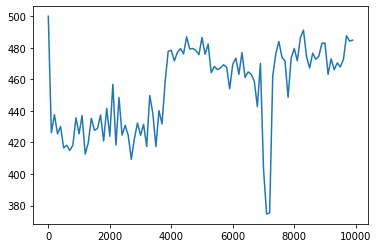

In [33]:
plt.plot(metrics['ep'], metrics['avg'], label="average rewards")

## Part 5: Plot one Animation

In [ ]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=20):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

frames = []

discrete_state = get_discrete_state(env.reset())

done = False

while not done:
  action = np.argmax(q_table[discrete_state])
  new_state, reward, done, _ = env.step(action)
  discrete_state = get_discrete_state(new_state)

  img = env.render(mode="rgb_array")
  frames.append(img)

plot_animation(frames)